We want to see:


* at least two graphs containing exploration of the dataset
* a statement of your question (or questions!) and how you arrived there
* the explanation of at least two new columns you created and how you did it
* the comparison between two classification approaches, including a qualitative discussion of  simplicity, time to run the model, and accuracy, precision, and/or recall
* the comparison between two regression approaches, including a qualitative discussion of * simplicity, time to run the model, and accuracy, precision, and/or recall
* an overall conclusion, with a preliminary answer to your initial question(s), next steps, and what other data you would like to have in order to better answer your question(s)

In [15]:
import pandas as pd
import numpy as np
import sys
from matplotlib import pyplot as plt
df = pd.read_csv("profiles.csv")
cols = df.shape[1]
rows = df.shape[0]
pd.set_option('display.max_columns', cols*2)

In [4]:
df.tail(1)

,age,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9,ethnicity,height,income,job,last_online,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
59945,39,average,NaN,socially,NaN,graduated from masters program,"is it odd that having a little ""enemy"" status ...",i work with elderly people (psychotherapy and ...,i'm a great bullshitter. i don't know what it ...,"either that i am funny/sarcastic, or that i am...","i just read the help by kathryn stockett, sooo...",1. family &amp; friends &amp; other humans - i...,"sex, myself, other people, how amazing everyth...","out at happy hour with my friends, running int...",i wish i could cry like holly hunter in broadc...,"if you have a back-bone, an opinion, a sense o...",white,68.0,-1,medicine / health,2012-06-29-00-42,"san francisco, california",NaN,gay,likes dogs and likes cats,catholicism and laughing about it,m,gemini and it&rsquo;s fun to think about,sometimes,english,single


In [9]:
import json
with open ("us_states.json", 'r') as f:
    us_state_abbrev = json.load(f)

<h3>Adding new columns - city, state, in the US, in CA, longtitude, and latitude</h3>

I wanted to add geolocation data for geomapping, but along the way found out that almost all of the data was in California.  Because of this, I just got geolocation data for California cities.  

It wasn't possible using the api I found to get geolocation data for all cities, but I was able to for almost all of them.

In [46]:
df['city'] = df.location.map(lambda l : l.split(", ")[0])
df['state'] = df.location.map(lambda l : l.split(", ")[1])
df['stateAbbr'] = df.state.map(lambda s : us_state_abbrev[s] if s in us_state_abbrev else s)
df['inUS'] = df.state.map(lambda s : s in us_state_abbrev)
df['inCA'] = df.state.map(lambda s : s == 'california')

inUS = df.inUS.value_counts()
inCA = df.inCA.value_counts()
print("{}% in US".format(inUS[1]/rows*100))
print("{}% in CA".format(inCA[1]/rows*100))

99.97831381576752% in US
99.84819671037268% in CA


Because 99.978% of the data are in the US and 99.848% of the data are in California, all non-California observations are going to be ignored for any geo-location summary information.

In [57]:
import requests
def getLatLong(location):
    print(".", end="")
    response = requests.get("http://open.mapquestapi.com/geocoding/v1/address?key=pxVoRtOLk6bTqJAGmcCdLY9ZrLGA707h&location={}".format(location))  
    try:
        response = response.json()
        state = location.split(", ")[1]
        latLong = None
        for data in response['results'][0]['locations']:
            if state == data['adminArea3']:
                latLong = data['latLng']
        if not latLong: # could not find the actual state's data
            raise
        lat = latLong['lat']
        long = latLong['lng']
        return lat, long
    except:
        print(" {} missing ".format(location), end="")
        return None, None

First, we need to find unique locations and get the latitude and longtitude for them.  I am using an api key from mapquest and their geocoding api to do this.

In [68]:
locations = df.location.value_counts().index
location_counts = list(df.location.value_counts())
location_dict = {}

for location, count in zip(locations,location_counts):
    city = location.split(", ")[0]
    state = location.split(", ")[1]
    if not state == 'california':
        continue
    lat, long = getLatLong("{}, CA, US".format(city))
    if not lat:
        continue
    location_dict[city] = {"count": count, "lat": lat, "long": long}

.......................... martinez, CA, US missing ..... albany, CA, US missing .............. green brae, CA, US missing ..... belvedere tiburon, CA, US missing .... crockett, CA, US missing . el granada, CA, US missing ...... piedmont, CA, US missing .. westlake, CA, US missing .......... san diego, CA, US missing . santa cruz, CA, US missing ..... bayshore, CA, US missing .... kensington, CA, US missing ....... irvine, CA, US missing ..... union city, CA, US missing ...... modesto, CA, US missing ........... long beach, CA, US missing . pasadena, CA, US missing . canyon, CA, US missing .. arcadia, CA, US missing ........... chico, CA, US missing ....... ashland, CA, US missing .

In [71]:
df['lat'] = df.city.map(lambda c : location_dict[c]['lat'] if c in location_dict else None)
df['long'] = df.city.map(lambda c : location_dict[c]['long'] if c in location_dict else None)

Because this takes a while to fetch this data, I am saving the dataframe and geolocation data with counts in the next frame and reloading it in the following frame.  I can start from there in the future.

In [77]:
df.to_csv("profilesWithGeoData.csv")
import json
with open('location_dict.json', 'w') as f:
    json.dump(location_dict, f)

<h3>Start from here in the future (no need to redo getting geolocation data)</h3>

In [1]:
import pandas as pd
import numpy as np
import sys, json
from matplotlib import pyplot as plt

with open('location_dict.json', 'r') as f:
    location_dict = json.load(f)

df = pd.read_csv("profilesWithGeoData.csv", index_col=0)
cols = df.shape[1]
rows = df.shape[0]
pd.set_option('display.max_columns', cols*2)
df.head(1)

,age,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9,ethnicity,height,income,job,last_online,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status,city,state,stateAbbr,inUS,inCA,lat,long
0,22,a little extra,strictly anything,socially,never,working on college/university,about me:<br />\r\n<br />\r\ni would love to t...,currently working as an international agent fo...,making people laugh.<br />\r\nranting about a ...,"the way i look. i am a six foot half asian, ha...","books:<br />\r\nabsurdistan, the republic, of ...",food.<br />\r\nwater.<br />\r\ncell phone.<br ...,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet!<br />\r\ny...,"asian, white",75.0,-1,transportation,2012-06-28-20-30,"south san francisco, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism and very serious about it,m,gemini,sometimes,english,single,south san francisco,california,CA,True,True,37.654949,-122.408125


In [3]:
!{sys.executable} -m pip install -q folium
import folium
import math


MAX_COUNT = math.log(list(df.location.value_counts())[0])
MIN_LISTINGS = 10
color_scaler = (MAX_COUNT)/255
def percToRed(perc):
    return '#%02x%02x%02x' % (255, 255-int(perc*255), 255-int(perc*255))

# map centered on US
dating_map = folium.Map(location=[36.7783, -119.4179], zoom_start=6)

for location, data in location_dict.items():
    count = data['count']
    if count < MIN_LISTINGS:
        continue # ignore locations with less than MIN_LISTINGS listings
    percent = math.log(count)/MAX_COUNT
    color = percToRed(percent)
    folium.CircleMarker(
        [data['lat'], data['long']],
        radius=5,
        popup=folium.Popup("{} ({} listings)".format(location, count), parse_html=True),
        fill=True,
        color=color,
        fill_color=color,
        fill_opacity=0.6
        ).add_to(dating_map)

<h3>First 'graph' - listing density by geolocation</h3>

The map below shows the density of listings by geolocation.  The log of the number of listings per location was taken, as otherwise everything but San Francisco would be white. 

(the scale for the map markers is white to red, white being low density of listings and red being high)

In [3]:
dating_map

In [3]:
body_map = {"thin":0, "skinny":1, "athletic":2,"fit":3, "jacked": 4, "average":5, "a little extra":6, 
            "curvy":7, "full figured":8, "used up": 9,  "overweight": 10, "rather not say": 11 }
df.body_type.value_counts()

average           14652
fit               12711
athletic          11819
thin               4711
curvy              3924
a little extra     2629
skinny             1777
full figured       1009
overweight          444
jacked              421
used up             355
rather not say      198
Name: body_type, dtype: int64

Text(0,0.5,'Number of respondents')

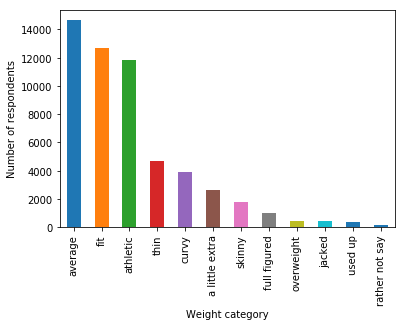

In [4]:
ax = df.body_type.value_counts().plot(kind='bar')
ax.set_xlabel('Weight category')
ax.set_ylabel('Number of respondents')

In [5]:
drinks_map = {"not at all": 0, "rarely": 1, "socially": 2, "often": 3, "very often": 4, "desperately": 5}
df.drinks.value_counts()

socially       41780
rarely          5957
often           5164
not at all      3267
very often       471
desperately      322
Name: drinks, dtype: int64

In [6]:
drugs_map = {"never": 0, "sometimes": 1, "often": 2}
df.drugs.value_counts()

never        37724
sometimes     7732
often          410
Name: drugs, dtype: int64

In [7]:
smokes_map = {"no": 0, "when drinking": 1, "sometimes": 2, "trying to quit": 3, "yes": 4 }
df.smokes.value_counts()

no                43896
sometimes          3787
when drinking      3040
yes                2231
trying to quit     1480
Name: smokes, dtype: int64

In [8]:
sex_map = {"f": 0, "m": 1}
df.sex.value_counts()

m    35829
f    24117
Name: sex, dtype: int64

In [9]:
education_map = {'dropped out of high school': 0, 'dropped out of space camp': 1, 'working on high school': 2, 'high school': 3, 'graduated from high school': 4, 'working on space camp': 5, 'space camp': 6, 'graduated from space camp': 7, 'dropped out of two-year college': 8, 'dropped out of college/university': 9, 'working on two-year college': 10, 'two-year college': 11, 'graduated from two-year college': 12, 'working on college/university': 13, 'college/university': 14, 'graduated from college/university': 15, 'dropped out of masters program': 16, 'dropped out of law school': 17, 'dropped out of med school': 18, 'dropped out of ph.d program': 19, 'working on masters program': 20, 'masters program': 21, 'graduated from masters program': 22, 'working on law school': 23, 'law school': 24, 'graduated from law school': 25, 'working on med school': 26, 'med school': 27, 'graduated from med school': 28, 'working on ph.d program': 29, 'ph.d program': 30, 'graduated from ph.d program': 31}

In [10]:
df['drinks_scale'] = df.drinks.map(lambda d: d if not d in drinks_map else drinks_map[d])
df['drugs_scale'] = df.drugs.map(lambda d: d if not d in drugs_map else drugs_map[d])
df['smokes_scale'] = df.smokes.map(lambda d: d if not d in smokes_map else smokes_map[d])
df['sex_scale'] = df.sex.map(lambda d: d if not d in sex_map else sex_map[d])
df['education_scale'] = df.education.map(lambda d: d if not d in education_map else education_map[d])

In [12]:
df.income.value_counts()

-1          48442
 20000       2952
 100000      1621
 80000       1111
 30000       1048
 40000       1005
 50000        975
 60000        736
 70000        707
 150000       631
 1000000      521
 250000       149
 500000        48
Name: income, dtype: int64

Most values of income are equal to -1; this seems to be unreported.  Because of this, I am going to create a new column, income_reported for the reporting or not of income (1 for reported, 0 for not).

In [18]:
df['income_reported'] = df.income.map(lambda i: 0 if i < 0 else 1)
df['income'] = df.income.map(lambda i: 0 if i < 0 else i)

In [19]:
df.tail(1)

,age,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9,ethnicity,height,income,job,last_online,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status,city,state,stateAbbr,inUS,inCA,lat,long,drinks_scale,drugs_scale,smokes_scale,sex_scale,education_scale,income_reported
59945,39,average,NaN,socially,NaN,graduated from masters program,"is it odd that having a little ""enemy"" status ...",i work with elderly people (psychotherapy and ...,i'm a great bullshitter. i don't know what it ...,"either that i am funny/sarcastic, or that i am...","i just read the help by kathryn stockett, sooo...",1. family &amp; friends &amp; other humans - i...,"sex, myself, other people, how amazing everyth...","out at happy hour with my friends, running int...",i wish i could cry like holly hunter in broadc...,"if you have a back-bone, an opinion, a sense o...",white,68.0,0,medicine / health,2012-06-29-00-42,"san francisco, california",NaN,gay,likes dogs and likes cats,catholicism and laughing about it,m,gemini and it&rsquo;s fun to think about,sometimes,english,single,san francisco,california,CA,True,True,37.779281,-122.419236,2.0,NaN,2.0,1,22.0,0


<h3>Correlation matrix between quantifiable features of the dataset</h3>

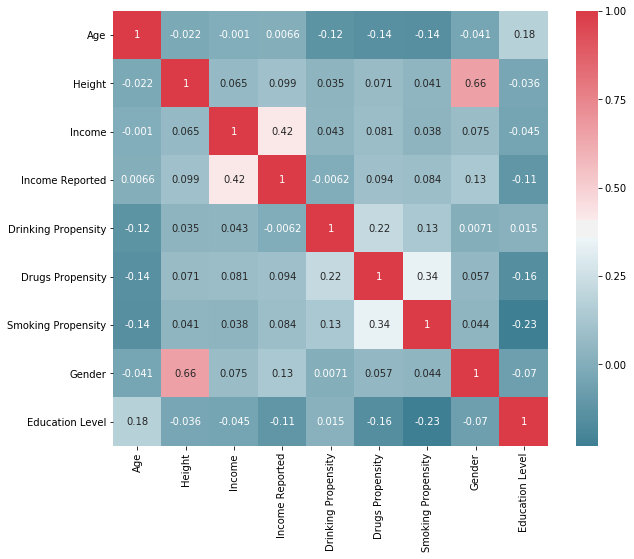

In [20]:
from matplotlib.pyplot import figure
import seaborn as sns

correlation_data = df[['age', 'height', 'income', 'income_reported', 'drinks_scale', 'drugs_scale', 'smokes_scale', 'sex_scale', 'education_scale']]
correlation_data.columns = ['Age', 'Height', 'Income', 'Income Reported', 'Drinking Propensity', 'Drugs Propensity', 'Smoking Propensity', 'Gender', 'Education Level']

f, ax = plt.subplots(figsize=(10, 8))
corr = correlation_data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True)


Only a few obvious correlations stand out - education and age, drug use and education (lower with higher education), smoking and education (lower with higher ecducation), and gender and height (obviously).

Some weaker correlations are gender and income, height and income, and drug use and smoking for males, as well as drug use and height.    

And then there are some correlations between reported income and drug use, smoking, height, gender, and education!  None of them are particurly strong, but there seem to be quite a few things correlated with reported income. 

<h3>Pairwise plots - click on left bar to the left of plots to expand all</h3>

c:\users\jeremy\miniconda\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


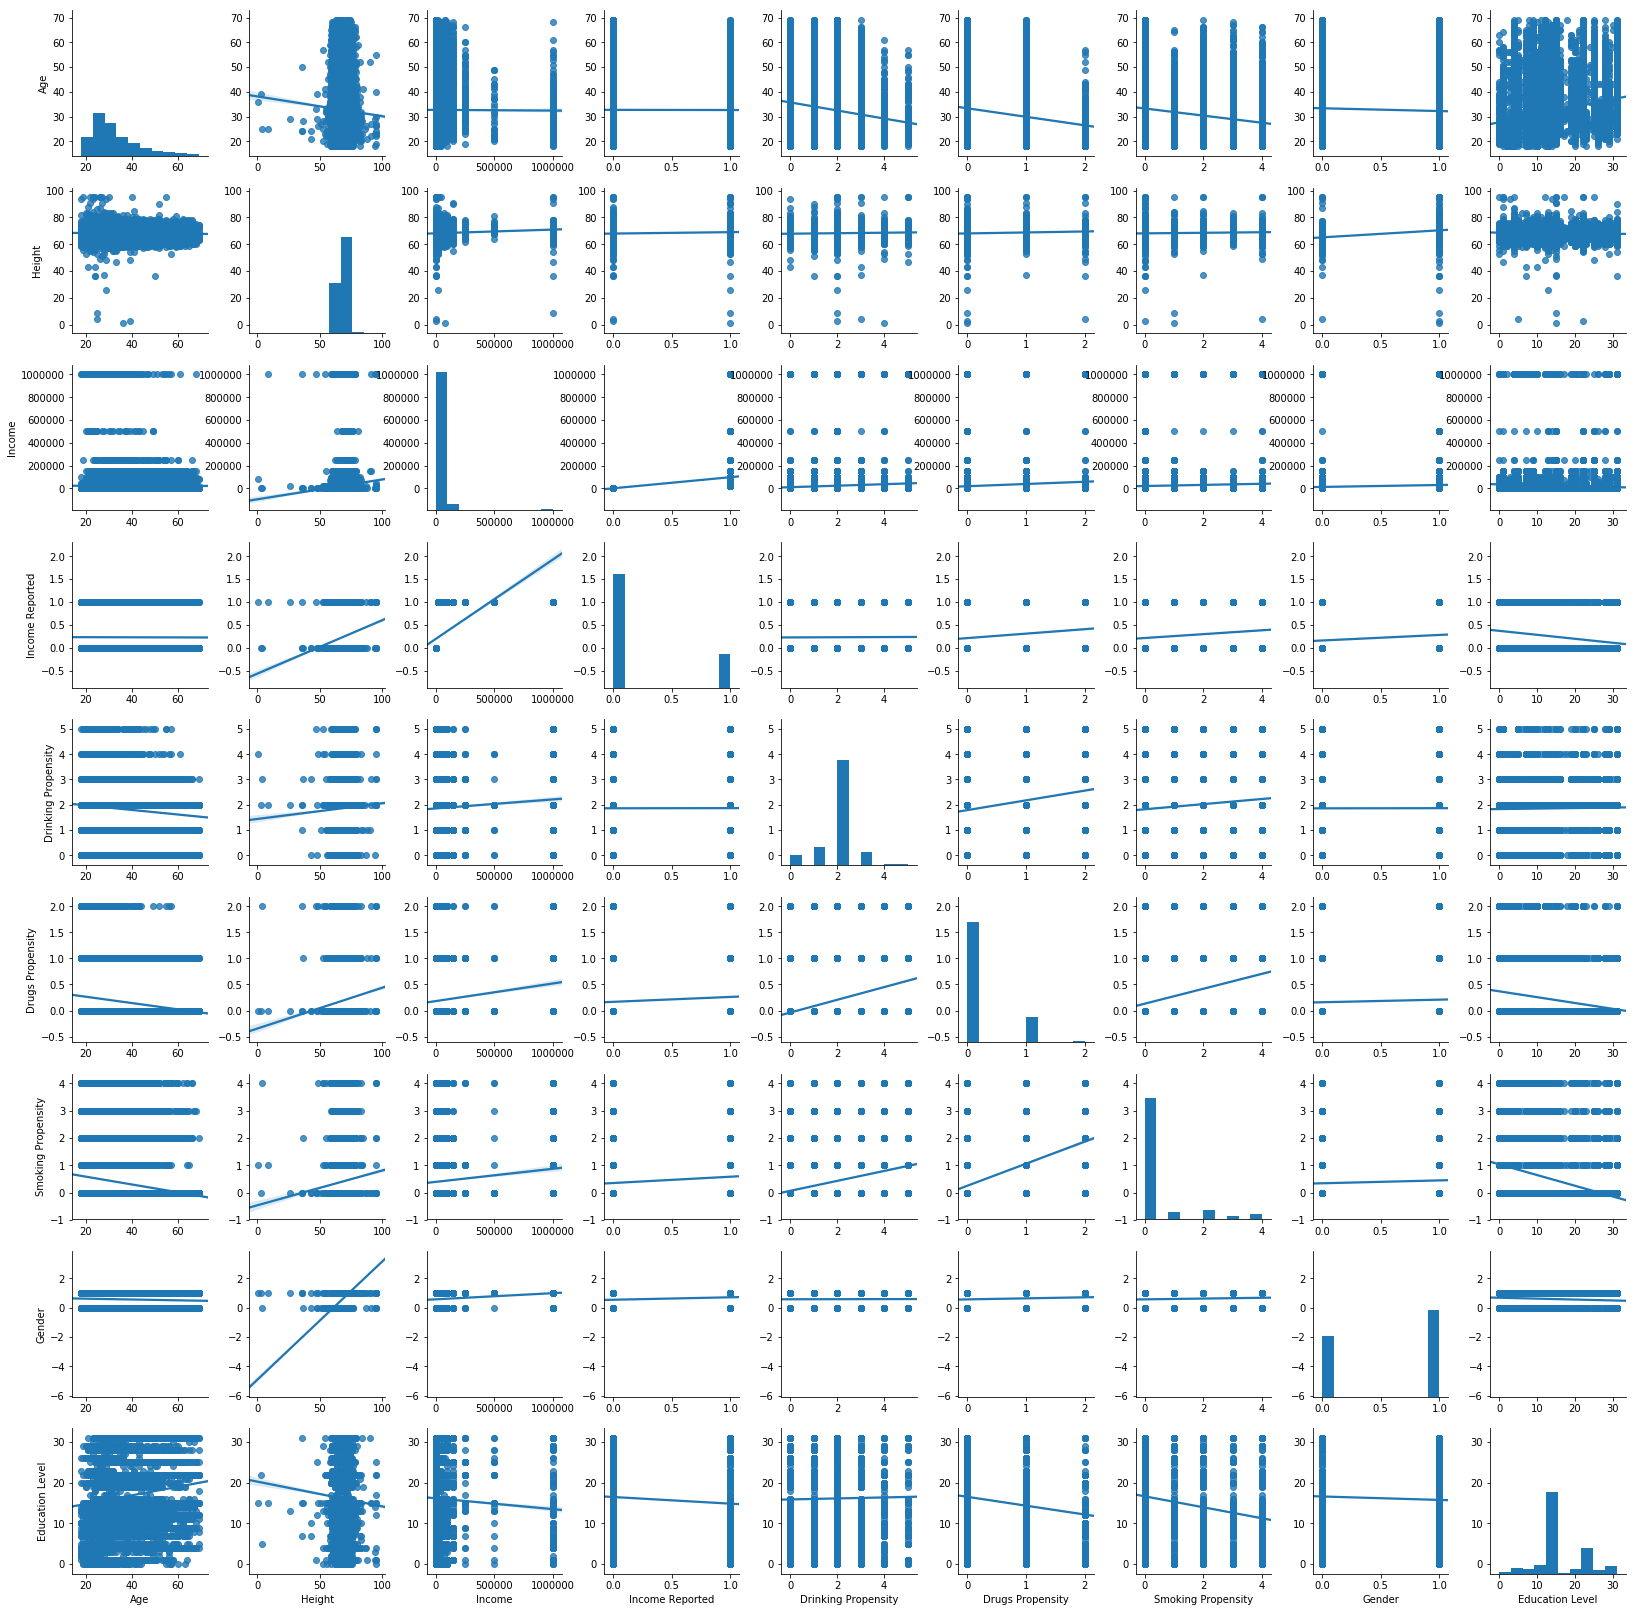

In [22]:
import seaborn
seaborn.pairplot(correlation_data.dropna(), kind="reg")

<h3>Dealing with NaN values</h3>

For drinking, drugs, smoking, and education, there were a good number of missing values.  It is likely that non-reporting of these values has some bias inherent; my guess is people who drink or use or smoke would be slightly more likely to not respond than those who do not.

Because of this and the inability to measure the degree of the bias (this is a self-reported survey, there is no way to find out the degree of the bias), it is safer to drop any observations with NaN values than to estimate their values.  

In [92]:
final_df = correlation_data.dropna()
final_df = final_df.reset_index()
final_df = final_df.drop('index', axis=1)
print("Before dropping: {} observations.\nAfter dropping: {} observations".format(
    correlation_data.shape[0],final_df.shape[0]))

Before dropping: 59946 observations.
After dropping: 38688 observations


And, we need to look at the distribution of reported / non-reported income after this:

In [93]:
print(final_df['Income Reported'].value_counts())
final_df.tail()

0    29874
1     8814
Name: Income Reported, dtype: int64


,Age,Height,Income,Income Reported,Drinking Propensity,Drugs Propensity,Smoking Propensity,Gender,Education Level
38683,31,62.0,0,0,2.0,0.0,0.0,0,20.0
38684,59,62.0,0,0,2.0,0.0,0.0,0,15.0
38685,24,72.0,0,0,3.0,1.0,0.0,1,13.0
38686,42,71.0,100000,1,0.0,0.0,0.0,1,22.0
38687,27,73.0,0,0,2.0,2.0,3.0,1,13.0


<h3>Research question and how I arrived there</h3>

The fact that most people do not report their income is unsurprising given its private nature and our culture (in many cultures people are much more open about their income), but it is also quite intriguing to consider whether other quantifiable factors are related to the reporting of income or not, especially after viewing the many correlations with reported income that exist in the data.

So, my research question came to be:

Can reported income be accurately classified and what are the factors that contribute to whether it was reported or not?  

Unfortunately, the dataset is entirely self-reported, so our confidence in the results in any question posed will be undermined by self-reporting bias, but there is nothing to be done about that.

Since we are required to not only do classification but regression, I have decided to use KNN and SVM for classification, and logistic regression and multiple linear regression for regression.

Since the data does not need to be normalized for logistic or multiple linear regression and interpretation will be clearer without normalization, we will start there.

In [113]:
y = final_df['Income Reported']
X = final_df
X = X.drop('Income', axis=1)
X = X.drop('Income Reported', axis=1)

In [61]:
!{sys.executable} -m pip install -q scikit-plot

In [143]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def showConfusionMatrixAndMore(model, model_type, X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    
    model.fit(X_train, y_train)
    y_predictions = model.predict(X_test)
    y_predictions = [0 if pred < 0.5 else 1 for pred in y_predictions]
    confmat = confusion_matrix(y_true=y_test, y_pred=y_predictions)
    
    fig, ax = plt.subplots(figsize=(2.5,2.5))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion matrix for {}'.format(model_type), y=1.2)
    plt.show()
    precision = precision_score(y_true=y_test, y_pred=y_predictions)
    recall = recall_score(y_true=y_test, y_pred=y_predictions)
    accuracy = accuracy_score(y_true=y_test, y_pred=y_predictions)
    print("""
    Precision was: {}
    Accuracy was: {}
    Recall was: {}
    """.format(precision,accuracy,recall))
    
    

In [190]:
from scipy import interp
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

def showROC(classifier, model_type, X, y):
    plt.figure(figsize=(7,7))
    cv = StratifiedKFold(n_splits=6)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(X, y):
        fit = classifier.fit(X.loc[train], y[train])
        if 'predict_proba' in dir(fit): # model has a predict probabilities function            
            probas_ = [prob[1] for prob in fit.predict_proba(X.loc[test])]
        else: # model only has a predict function
            probas_ = [0 if prob < 0.5 else 1 for prob in fit.predict(X.loc[test])]
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for {}'.format(model_type))
    plt.legend(loc="lower right")
    plt.show()

<h3>Logistic Regression</h3>

Logistic regression has the benefit of being very simple to perform, so we will start there.

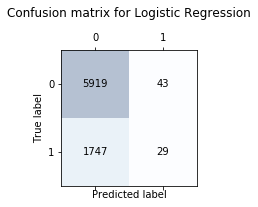


    Precision was: 0.4027777777777778
    Accuracy was: 0.7686740759886276
    Recall was: 0.01632882882882883
    


In [144]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression()
showConfusionMatrixAndMore(logit, 'Logistic Regression', X, y)

Well, the model is accurate for the very few observations it classified as reported, but it chose to guess unreported for the vast majority of cases, so it is extremely imprecise.

For a lot more information, let's look at the ROC curve:

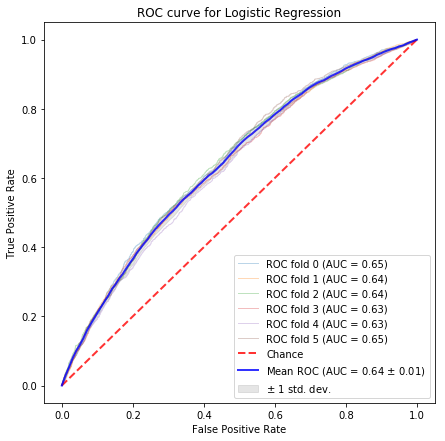

In [176]:
showROC(logit,'Logistic Regression', X,y)

This shows the model does have some predictive power!  It's not great, but that's probably to be expected given the thing we are trying to predict.

In [186]:
import statsmodels.discrete.discrete_model as sm

logit_reg = sm.Logit(y, X)
logit_reg.fit().summary()

Optimization terminated successfully.
         Current function value: 0.516644
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        Income Reported   No. Observations:                38688
Model:                          Logit   Df Residuals:                    38681
Method:                           MLE   Df Model:                            6
Date:                Wed, 02 Jan 2019   Pseudo R-squ.:                 0.03725
Time:                        12:08:40   Log-Likelihood:                -19988.
converged:                       True   LL-Null:                       -20761.
                                        LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Age                     0.0074      0.001      5.776      0.000       0.005       0.010
Height                 -0.0189      0.001    -19.017      0.000      -0.021      -0.017
Drinking Propensity    -0.0547      0.017     -3.231      0.001      -0.088      -0.021
Drugs Propensity        0.3371      0.030     11.146      0.000       0.278       0.396
Smoking Propensity      0.1141      0.012      9.165      0.000       0.090       0.138
Gender                  0.7684      0.029     26.902      0.000       0.712       0.824
Education Level        -0.0426      0.002    -18.636      0.000      -0.047      -0.038
=======================================================================================
"""

From the actual regression, we can see that the p-values for every included feature (all numerical features in general) are all highly significant - p values all less than 0.001 indicate that every feature has an effect on whether someone reported income or not.  

The magnitude is strongest for education level (since the scale of education is 0-31, whereas the scale for Drugs propensity is only 0-2.  If you normalize according to this then you will see that education has a greater effect than drugs) , followed by gender and drug use, and then height, then age, then smoking.

It turns out that this is an interesting research question with predictors that are all significant, but where actual prediction of the outcome is not easy under logistic regression (probably under all models, but we shall see...)

<h3>Multiple Linear Regression</h3>

Let's compare old ordinary least squares multiple linear regression and see if logistic regression does a better job or not.   

The commentary above explains a lot of what was done for logistic regression, and much of it will not be repeated here.

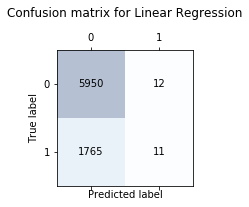


    Precision was: 0.4782608695652174
    Accuracy was: 0.7703540966658051
    Recall was: 0.006193693693693694
    


In [184]:
from sklearn.linear_model import LinearRegression

linear = LinearRegression()
showConfusionMatrixAndMore(linear, 'Linear Regression', X, y)

Both linear and logistic regression make too few guesses for income reported to make any meaningful commentary about the precision of each model.  Linear regression has a higher number, but a lower amount of positive predictions

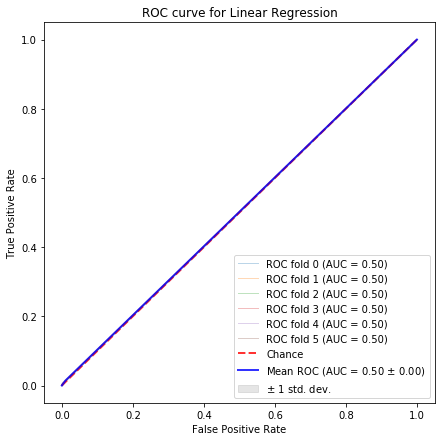

In [193]:
showROC(linear,'Linear Regression', X,y)

Ouch!  I guess that means multiple linear regression is horrible as a classifier!  Luckily, we're not doing classification, but regression.  Let's see how it did on that front.

In [191]:
import statsmodels.discrete.discrete_model as sm

linear_reg = sm.OLS(y, X)
linear_reg.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Income Reported   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     1943.
Date:                Wed, 02 Jan 2019   Prob (F-statistic):               0.00
Time:                        12:09:12   Log-Likelihood:                -20453.
No. Observations:               38688   AIC:                         4.092e+04
Df Residuals:                   38681   BIC:                         4.098e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Age                     0.0016      0.000      7.337      0.000       0.001       0.002
Height                  0.0033      0.000     19.373      0.000       0.003       0.004
Drinking Propensity    -0.0073      0.003     -2.483      0.013      -0.013      -0.002
Drugs Propensity        0.0624      0.006     11.315      0.000       0.052       0.073
Smoking Propensity      0.0241      0.002     10.402      0.000       0.020       0.029
Gender                  0.0953      0.005     20.866      0.000       0.086       0.104
Education Level        -0.0068      0.000    -18.049      0.000      -0.008      -0.006
==============================================================================
Omnibus:                     6257.150   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9670.447
Skew:                           1.216   Prob(JB):                         0.00
Kurtosis:                       2.718   Cond. No.                         208.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can see the importance and significance of each feature take on about the same values as in the logistic regression.  Remember, the coefficients on OLS are different than the odds ratios in logistic regression.  Nonetheless, the ratios between the different features, and their direction of prediction, are all about the same.

This means that regular OLS is good at looking for the predictive features of whether income was reported or not, but does a horrible job at classification.

<h3>K-Nearest Neighbors</h3>

Next up, KNN.  Our first 100% classification approach!

But first, we need to scale all of the predictors because the following models need to be normalized to work optimally.

In [195]:
normalized_X=(X-X.mean())/X.std()

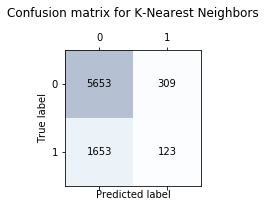


    Precision was: 0.2847222222222222
    Accuracy was: 0.7464461101059705
    Recall was: 0.06925675675675676
    


In [198]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=2)

showConfusionMatrixAndMore(knn, 'K-Nearest Neighbors', normalized_X, y)

Precision is down from the regression models, but the amount of positive predictions is way higher, so the models cannot be directly compared.  Let's see about the ROC curve:

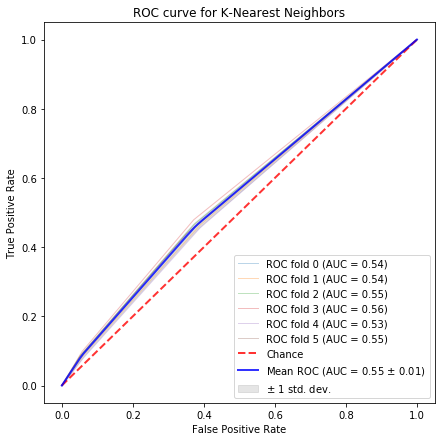

In [203]:
showROC(knn,'K-Nearest Neighbors', normalized_X,y)

K-Nearest Neighbors does have some predictive power, but it seems like logistic regression is in the lead.  It's unsurprising given that this is a binary classification problem!

Finally, let's do Support Vector Machines!

In [205]:
from sklearn import svm
svm = svm.SVC()

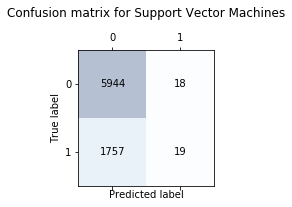


    Precision was: 0.5135135135135135
    Accuracy was: 0.7706125613853709
    Recall was: 0.010698198198198198
    


In [201]:
showConfusionMatrixAndMore(svm, 'Support Vector Machines', normalized_X, y)

Well, the precision is slightly better than the regression models, and the postive predictions are about the same, so perhaps SVM is the best model so far, or perhaps it is just a result of very few positive predictions in general.  Let's see what the ROC curve can show us.

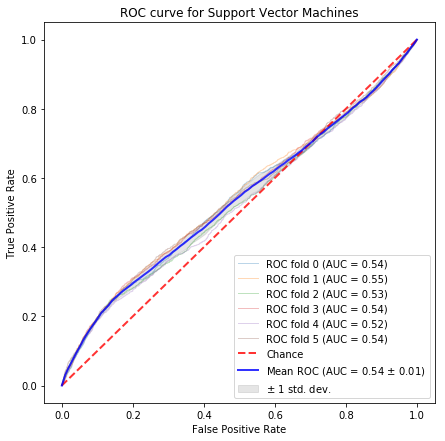

In [207]:
svm.probability = True #Trick SVM from scikit learn to predict probabilities
showROC(svm,'Support Vector Machines', normalized_X,y)

SVM is definitely the most complex model to run on this data.  It also takes by far the most time to run, **about an hour** for a dataset that is pretty small (less than 40,000 observations).  

However, it was still beaten by both logistic regression and k-nearest neighbors.

<h3>Conclusion</h3>

The regressions performed clearly show that the numerical features of the dataset all help predict whether someone will report their own income or not, in the following order of importance (the direction, + meaning more likely to report and - meaning less likey, is in paranthesis):

* Education (-)
* Drug use (+)
* Gender (+ -> males)
* Height (-)
* Age (+)
* Smoking (+)

The actual classification part of the problem did not go as well.  The ROC curves, especially of logistic regression, show that there is some predictive power to the models (outside of linear regression), but it probably is not strong enough to be of practical use.

**Next steps**

In depth text analysis of the essays of dating profiles could be done; this could be transformed into a proxy for writing skill which might not perfectly correlate with education level (you don't necessarily have to get a higher degree to be well educated).  This might give more predictive power to the model.

Also, although the data seems fairly linear, it might be worth exploring the linearity of the relationship for each feature in turn.  This also might improve the predictive power of the model a little bit.

**Other data**

If there were a way to get the actual incomes of respondents and verify their other reported characteristics, we could see the amount of bias in various reported features, and adjust for it accordingly.  This might increase the predictive power of the various models slightly.

Other quantitative predictors (more in depth profiles, perhaps asking quantifiable questions such as number of sexual partners, ) could add further predictive power to the models if it were available.

Finally, the results might just be specific to San Francisco, where almost all of the data in the dataset comes from.  It would be interesting to compare whether people reported income based on the type of place they lived (not possible in this dataset because almost all data comes from San Francisco), and a much larger dataset could help with that.